In [1]:
%cd C:\Users\yukir\Documents\GitHub\sign_detection\py

C:\Users\yukir\Documents\GitHub\sign_detection\py


In [2]:
from basic_preprocessing import *
from deeplearning_check import *

gpu_check()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11707310934972138885
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15346439900087708028
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9883535296
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13732833528033715468
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8555205904910495829
physical_device_desc: "device: XLA_GPU device"
]


#### dir

In [3]:
%cd C:\Users\yukir\Documents\Monicas_workspace\Datasets\0804\SIGN\output

C:\Users\yukir\Documents\Monicas_workspace\Datasets\0804\SIGN\output


In [6]:
train_dir = "train"
test_dir = "test"
val_dir = "val"

In [17]:
input_path = 'C:\\Users\\yukir\\Documents\\Monicas_workspace\\Datasets\\0804\\SIGN\\Up'

In [18]:
from sklearn.model_selection import train_test_split
import os
import splitfolders

splitfolders.ratio(input_path, output='output', seed=86, ratio=(0.8, 0.1, 0.1))

Copying files: 53 files [00:00, 1007.11 files/s]


In [19]:
count_img('C:\\Users\\yukir\\Documents\\Monicas_workspace\\Datasets\\0804\\SIGN\\Fragile\\Fragile')

이미지수 0


In [11]:
count_img('C:\\Users\\yukir\\Documents\\Monicas_workspace\\Datasets\\0804\\SIGN\\Up\\up_resized')

이미지수 53


#### basic model

In [27]:
%cd C:\Users\yukir\Documents\Monicas_workspace\Datasets\0804\SIGN\output\output

C:\Users\yukir\Documents\Monicas_workspace\Datasets\0804\SIGN\output\output


In [28]:
train_dir = "train"
test_dir = "test"
val_dir = "val"

In [29]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [34]:
from keras import Input
train_generator = train_datagen.flow_from_directory(train_dir, batch_size=16, target_size=(100,100), color_mode='rgb')
val_generator = val_datagen.flow_from_directory(val_dir, batch_size=16, target_size=(100, 100), color_mode='rgb')
 
input_tensor = Input(shape=(100, 100, 3), dtype='float32', name='input')

Found 110 images belonging to 2 classes.
Found 13 images belonging to 2 classes.


In [35]:
pre_trained_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
pre_trained_vgg.trainable = False
pre_trained_vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [36]:
additional_model = models.Sequential()
additional_model.add(pre_trained_vgg)
additional_model.add(layers.Flatten())
additional_model.add(layers.Dense(4096, activation='relu'))
additional_model.add(layers.Dense(2048, activation='relu'))
additional_model.add(layers.Dense(1024, activation='relu'))
additional_model.add(layers.Dense(2, activation='softmax'))
 
 
additional_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 4096)              18878464  
_________________________________________________________________
dense_5 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 2050      
Total params: 44,084,034
Trainable params: 29,369,346
Non-trainable params: 14,714,688
_________________________________

In [38]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(filepath='pretrained_VGG_weight.hdf5', 
            monitor='loss', 
            mode='min', 
            save_best_only=True)
 
additional_model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])
 
 
history = additional_model.fit_generator(train_generator, 
            steps_per_epoch=math.ceil(train_generator.n / train_generator.batch_size), 
            epochs=10, 
            validation_data=val_generator, 
            validation_steps=math.ceil(val_generator.n / val_generator.batch_size), 
            callbacks=[checkpoint])

Epoch 1/10
7/7 [==============================] - 1s 156ms/step - loss: 0.0991 - acc: 0.9818 - val_loss: 0.2613 - val_acc: 0.9231
Epoch 2/10
7/7 [==============================] - 1s 140ms/step - loss: 0.0400 - acc: 0.9909 - val_loss: 0.2531 - val_acc: 0.8462
Epoch 3/10
7/7 [==============================] - 1s 136ms/step - loss: 0.0296 - acc: 1.0000 - val_loss: 0.4269 - val_acc: 0.8462
Epoch 4/10
7/7 [==============================] - 0s 22ms/step - loss: 0.0337 - acc: 1.0000 - val_loss: 0.2273 - val_acc: 0.9231
Epoch 5/10
7/7 [==============================] - 1s 136ms/step - loss: 0.0208 - acc: 1.0000 - val_loss: 0.2225 - val_acc: 0.8462
Epoch 6/10
7/7 [==============================] - 1s 141ms/step - loss: 0.0148 - acc: 1.0000 - val_loss: 0.2434 - val_acc: 0.9231
Epoch 7/10
7/7 [==============================] - 0s 22ms/step - loss: 0.0212 - acc: 1.0000 - val_loss: 0.2477 - val_acc: 0.7692
Epoch 8/10
7/7 [==============================] - 1s 134ms/step - loss: 0.0124 - acc: 1.0000

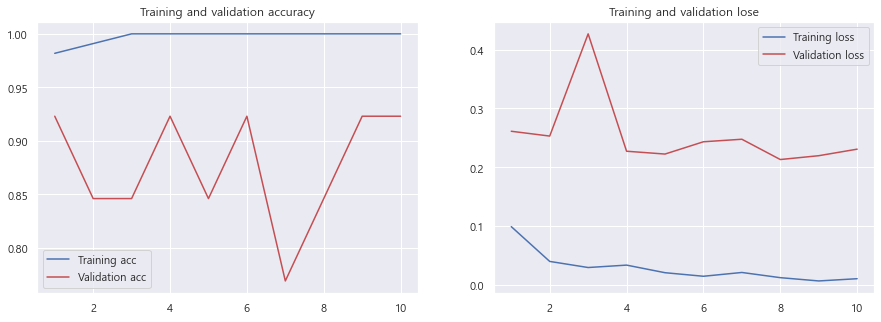

In [42]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) +1)
    
    

fig = plt.figure()
fig.set_size_inches(15, 5)

fig.add_subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label ='Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# plt.figure()
fig.add_subplot(1, 2, 2) 
plt.plot(epochs, loss, 'b', label = "Training loss")
plt.plot(epochs, val_loss, 'r', label ='Validation loss')
plt.title('Training and validation lose')
plt.legend()

plt.show()

In [44]:
additional_model.compile(optimizer = optimizers.RMSprop(lr=2e-5),
             loss='categorical_crossentropy',
             metrics=['accuracy',\
                      tf.keras.metrics.Precision(name='precision')\
                          ,tf.keras.metrics.Recall(name='recall')\
                          ,tf.keras.metrics.FalsePositives(name='false_positives')\
                          ,tf.keras.metrics.FalseNegatives(name='false_negatives'),\
                      tf.keras.metrics.TruePositives(name ='true_positives'),\
                     tf.keras.metrics.TrueNegatives(name ='true_negatives')])

In [47]:
test_generator = test_datagen.flow_from_directory(test_dir, batch_size=16, target_size=(100,100), color_mode='rgb')
result = additional_model.evaluate(test_generator)
type(result)

Found 16 images belonging to 2 classes.
1/1 [==============================] - 0s 0s/step - loss: 0.4184 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - false_positives: 3.0000 - false_negatives: 3.0000 - true_positives: 13.0000 - true_negatives: 13.0000


list

In [49]:
evaluating_each(additional_model, test_generator)

1/1 [==============================] - 0s 992us/step - loss: 0.4184 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - false_positives: 3.0000 - false_negatives: 3.0000 - true_positives: 13.0000 - true_negatives: 13.0000

loss:0.418, 
accuracy:0.812, 
precision:0.812, 
recall:0.812, 
False_positive:3, 
False_negative, :3, 
True_positive:13, 
True_negative:13, 
Sensitivity:0.812, 
Specificity:0.812, 
F1_score:0.812


(0.4184466600418091,
 0.8125,
 0.8125,
 0.8125,
 3,
 3,
 13,
 13,
 0.8125,
 0.8125,
 0.8124999500000031)

In [50]:
get_label_dict(train_generator)

{0: 'fragile_resized', 1: 'up_resized'}

In [51]:
a, b = get_pred_labels(additional_model, test_generator)
pred_label = list(a)
pred_label

Instructions for updating:
Please use Model.predict, which supports generators.
 1/16 [>.............................] - 0s 24ms/step


[0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0]

#### test_result

In [52]:
%cd C:\Users\yukir\Documents\Monicas_workspace\Datasets\0804\SIGN\output\output\test

C:\Users\yukir\Documents\Monicas_workspace\Datasets\0804\SIGN\output\output\test


In [108]:
up_test = 'up_resized\\'
fragile_test = 'fragile_resized\\'

In [109]:
print(count_img(up_test))
print(count_img(fragile_test))

이미지수 6
None
이미지수 10
None


In [110]:
def file_list(path):
    file_list = os.listdir(path)
    file_list.sort()
    
    list_file = []
    for i in file_list:
        list_file.append(path+i)
    return list_file

In [111]:
file_name =[]
for i in file_list(fragile_test):
    i = i.split('\\')[-1]
    file_name.append(i)
    
for j in file_list(up_test):
    j = j.split('\\')[-1]
    file_name.append(j)
file_name

['fragile_1.jpg',
 'fragile_11.jpg',
 'fragile_16.jpg',
 'fragile_20.jpg',
 'fragile_43.jpg',
 'fragile_45.jpg',
 'fragile_52.jpg',
 'fragile_67.jpg',
 'fragile_73.jpg',
 'fragile_81.jpg',
 'up_1.jpg',
 'up_27.jpg',
 'up_40.jpg',
 'up_51.jpg',
 'up_6.jpg',
 'up_7.jpg']

In [112]:
file_names=[]
for i in file_name:
    file_names.append(i.split('_')[0])
file_names[9]

'fragile'

In [113]:
get_label_dict(train_generator)

{0: 'fragile_resized', 1: 'up_resized'}

In [114]:
#result
result_df = pd.DataFrame({'File_label': file_names, "pred_label":pred_label})
result_df['pred_label_result'] = result_df.pred_label.replace(1, 'up')
result_df['pred_label_result'] = result_df.pred_label.replace(0, 'fragile')

In [115]:
result_df['file_name']= file_name

In [116]:
result_df['pred_label_result'] = result_df.pred_label_result.replace(1, 'up')
result_df.head()

,File_label,pred_label,pred_label_result,file_name
0,fragile,0,fragile,fragile_1.jpg
1,fragile,0,fragile,fragile_11.jpg
2,fragile,0,fragile,fragile_16.jpg
3,fragile,1,up,fragile_20.jpg
4,fragile,0,fragile,fragile_43.jpg


In [117]:
result_df.File_label.unique()

array(['fragile', 'up'], dtype=object)

In [118]:
result_df['Results'] = (result_df['File_label']==result_df['pred_label_result'])

In [119]:
result_df.head()

,File_label,pred_label,pred_label_result,file_name,Results
0,fragile,0,fragile,fragile_1.jpg,True
1,fragile,0,fragile,fragile_11.jpg,True
2,fragile,0,fragile,fragile_16.jpg,True
3,fragile,1,up,fragile_20.jpg,False
4,fragile,0,fragile,fragile_43.jpg,True


In [120]:
false_result = result_df['Results']==False
false_df = result_df[false_result]
false_df

,File_label,pred_label,pred_label_result,file_name,Results
3,fragile,1,up,fragile_20.jpg,False
5,fragile,1,up,fragile_45.jpg,False
8,fragile,1,up,fragile_73.jpg,False
9,fragile,1,up,fragile_81.jpg,False
13,up,0,fragile,up_51.jpg,False
14,up,0,fragile,up_6.jpg,False
15,up,0,fragile,up_7.jpg,False


#### checking image

In [121]:
false_img_list = false_df['file_name'].tolist()

In [122]:
/pwd

'C:\\Users\\yukir\\Documents\\Monicas_workspace\\Datasets\\0804\\SIGN\\output\\output\\test'

In [123]:
up_test

'up_resized\\'

In [128]:
up_false_list = false_img_list[-3:]

up_false_img_list = []
for i in up_false_list:
    path ='C:\\Users\\yukir\\Documents\\Monicas_workspace\\Datasets\\0804\\SIGN\\output\\output\\test\\'
    i = path+up_test+i
    up_false_img_list.append(i)
    
up_false_img_list

['C:\\Users\\yukir\\Documents\\Monicas_workspace\\Datasets\\0804\\SIGN\\output\\output\\test\\up_resized\\up_51.jpg',
 'C:\\Users\\yukir\\Documents\\Monicas_workspace\\Datasets\\0804\\SIGN\\output\\output\\test\\up_resized\\up_6.jpg',
 'C:\\Users\\yukir\\Documents\\Monicas_workspace\\Datasets\\0804\\SIGN\\output\\output\\test\\up_resized\\up_7.jpg']

In [ ]:
"C:\Users\yukir\Documents\Monicas_workspace\Datasets\0804\SIGN\output\output\test\up_resized\up_1.jpg"

In [129]:
fragile_false_list = false_img_list[:-3]

fragile_false_img_list = []
for i in fragile_false_list:
    path ='C:\\Users\\yukir\\Documents\\Monicas_workspace\\Datasets\\0804\\SIGN\\output\\output\\test\\'
    i = path+fragile_test+i
    fragile_false_img_list.append(i)
    
fragile_false_img_list

['C:\\Users\\yukir\\Documents\\Monicas_workspace\\Datasets\\0804\\SIGN\\output\\output\\test\\fragile_resized\\fragile_20.jpg',
 'C:\\Users\\yukir\\Documents\\Monicas_workspace\\Datasets\\0804\\SIGN\\output\\output\\test\\fragile_resized\\fragile_45.jpg',
 'C:\\Users\\yukir\\Documents\\Monicas_workspace\\Datasets\\0804\\SIGN\\output\\output\\test\\fragile_resized\\fragile_73.jpg',
 'C:\\Users\\yukir\\Documents\\Monicas_workspace\\Datasets\\0804\\SIGN\\output\\output\\test\\fragile_resized\\fragile_81.jpg']

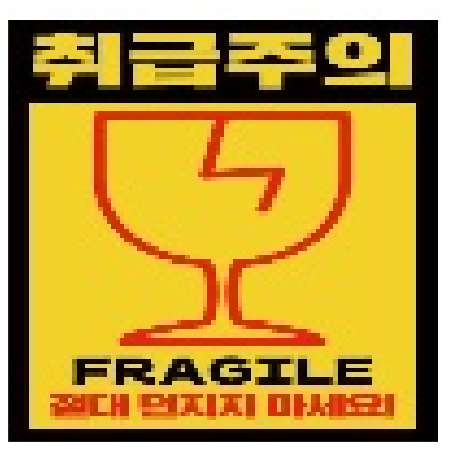

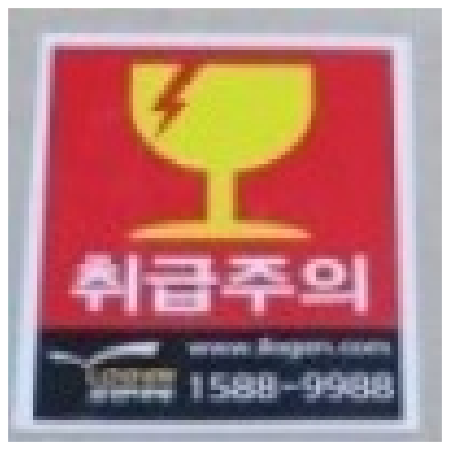

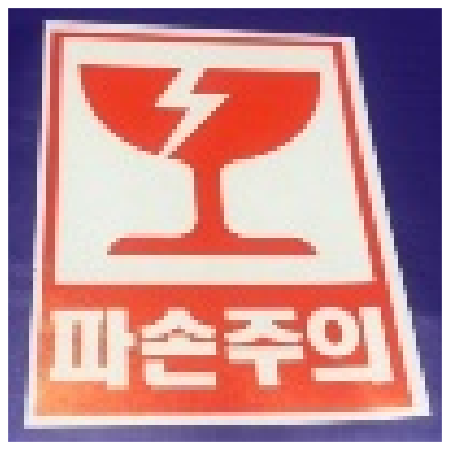

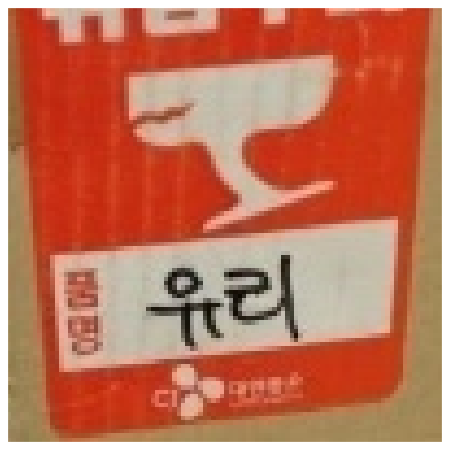

In [139]:
for i in fragile_false_img_list:
    i = INPUT_IMG(i)
    i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
    show(i)

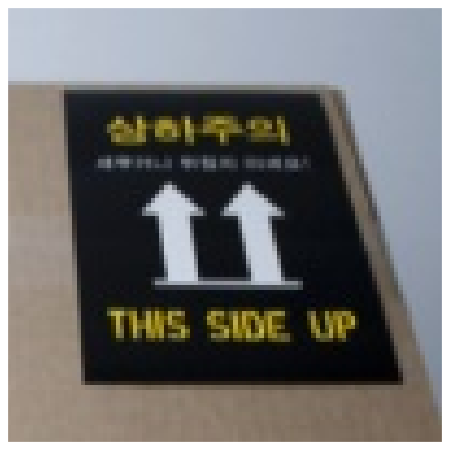

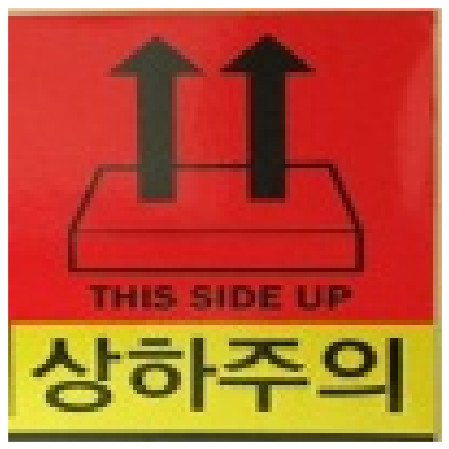

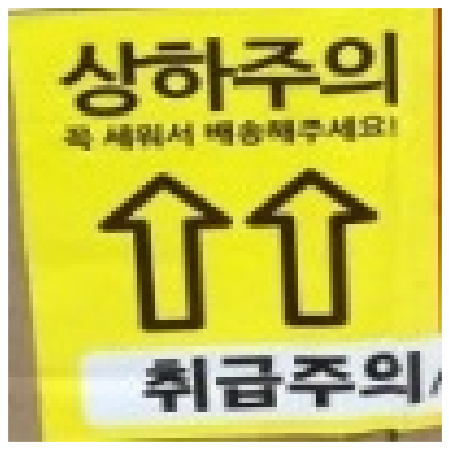

In [140]:
for i in up_false_img_list:
    i = INPUT_IMG(i)
    i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
    show(i)

#### checking model

In [142]:
model_path = "C:\\Users\\yukir\\Documents\\Monicas_workspace\\Sign detection\\meaningful\\weights\\[0804]pretrained_VGG_weight.hdf5"

In [143]:
model = keras.models.load_model(model_path)

In [145]:
real_path = 'C:\\Users\\yukir\\Documents\\Monicas_workspace\\Datasets\\real_pic_test\\resizing'
count_img(real_path)

이미지수 38


In [146]:
test_datagen = ImageDataGenerator(rescale=1./255)
real_test = test_datagen.flow_from_directory(real_path, batch_size=16, target_size=(50, 50), color_mode='rgb')

Found 0 images belonging to 0 classes.


In [147]:
test_img ="C:\\Users\\yukir\\Documents\\Monicas_workspace\\Datasets\\real_pic_test\\resizing\\1.jpg"

In [149]:
get_label_dict(train_generator)

{0: 'fragile_resized', 1: 'up_resized'}

In [150]:
def file_list(path):
    file_list = os.listdir(path)
    file_list.sort()
    file_list = file_list[1:]
    list_file = []
    for i in file_list:
        list_file.append(path+i)
    return list_file

path ='C:\\Users\\yukir\\Documents\\Monicas_workspace\\Datasets\\real_pic_test\\resizing\\'

file_list = file_list(path)

results={
   0:'fragile',
   1:'up',
   2:'bird',
   3:'cat',
   4:'deer',
   5:'dog',
   6:'frog',
   7:'horse',
   8:'ship',
   9:'truck'
}
columns =['file_name', 'label', 'class']
answer = []
for i in file_list:
    im=Image.open(i)
    # the input image is required to be in the shape of dataset, i.e (32,32,3)
    i= i.split('\\')[-1]
    im=im.resize((100,100))
    im=np.expand_dims(im,axis=0) #차원으로 분리
    im=np.array(im)
    pred=model.predict_classes([im])[0]
    answer.append([i, pred, results[pred]])
    answer_df = pd.DataFrame(answer, columns = columns )
answer_df.head()

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


,file_name,label,class
0,(2)blankstock180501065.jpg,0,fragile
1,1.jpg,0,fragile
2,blankstock180501065.jpg,0,fragile
3,grunge-fragile-box-sign-with-arrow-up-on-piece...,0,fragile
4,images (1).jpg,0,fragile


In [153]:
answer_df["class"].value_counts()

fragile    33
up          4
Name: class, dtype: int64

#### h5f 파일읽기

In [154]:
import h5py

In [159]:
h5f = h5py.File(model_path, 'r')
for key in h5f.keys():
    print(key)

model_weights
optimizer_weights
